## Verrijkte kleinverbruikergegevens
Creer een nieuwe dataset obv de NEDU profielen en de kleinverbruikergegevens. De nieuwe dataset bevat dan het kleinverbruik per dag per postcode.

De stappen die genomen worden zijn:

1. Inlezen h5 bestanden met de NEDU profielen en kleinverbruikergegevens
2. Voeg profiel toe aan kleinverbruikergegevens
3. Transformeer NEDU profielen set tot een verbruik per dag ipv verbruik per kwartier
4. Nieuw dataframe opbouwen met per dag de volgende data:
* Datum
* Verbruik
* Postcode
* Aantal aansluitingen

Om het juiste profiel te bepalen nemen we 2 dingen mee:
* Wat is percentage meters met een Laag/Hoog tarief. Als dit percentage lager is dan 30% wordt het gebied in een A profiel gezet.
* Ligt het gebied in Noord of Zuid-Nederland. Dit wordt gebruikt om te bepalen of het gebied een E1B of E1C profiel krijgt.

Het verbruik wordt berekend door het verbruik van het profiel behorende bij de postcode te sommeren voor een dag.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

# show all columns in the dataframe
pd.set_option('max_columns', None)

In [2]:
os.getcwd()

'c:\\Users\\ericr\\OneDrive - Actondata\\Projecten\\jads_enexis\\notebooks'

In [3]:
# variables used in script
data_processed_location = '../data/processed'

if 'processed' not in os.getcwd():
    os.chdir(data_processed_location)

# kleinverbruikgegevens gegevens inlezen
df_verbruik = pd.read_hdf('kleinverbruikgegevens_data.h5')

# NEDU profielen
df_nedu_profielen = pd.read_hdf('nedu_files.h5')
df_transform_nedu = pd.read_hdf('nedu_files_transformed.h5')

# mapping van PC4 buurt naar RES regio
df_pc4_res = pd.read_hdf('pc4_res.h5')

In [4]:
# Laat alle soorten aansluitingen zien
df_verbruik.SOORT_AANSLUITING.unique()

array(['1X25', '3X25', '1X35', '3X35', '3X63', '1X40', '3X80', '3X50',
       '1X20', '3X40', '1x25', '3x25', '1x35', '1x40', '3x35', '3x63',
       '3x80', '3x50', '3x40', '1x20'], dtype=object)

In [6]:
profiel_E1 = ['1X25','3X25', '1X20', '1x25', '3x25', '1x20'] # de rest is profiel E2

# Voeg in de kleinverbruikgegevens, het bijpassende profiel voor de soort aansluiting toe
def vervang_door_profiel(aansluiting, postcode, percentage):
    # Bepaal basisprofiel
    profiel = 'E1' if aansluiting in profiel_E1 else 'E2'

    # Een laag tarief percentage lager dan 30% zetten we in een A profiel
    lh_profiel = 'A' if percentage < 30 else 'B'

    # Bepaal welk laag tarief gebied de postcode zit
    if profiel == 'E1' and lh_profiel == 'B':
        postcode_area = int(postcode[:2]) # PC4
        # Postcodes < 65 is Noord-Brabant of Limburg
        if postcode_area < 65:
            lh_profiel = 'C'
    return profiel + lh_profiel

df_verbruik["PROFIEL"] = np.vectorize(vervang_door_profiel)(df_verbruik.SOORT_AANSLUITING, df_verbruik.POSTCODE_VAN, df_verbruik.SJV_LAAG_TARIEF_PERC)
df_verbruik.head()

,NETBEHEERDER,NETGEBIED,STRAATNAAM,POSTCODE_VAN,POSTCODE_TOT,WOONPLAATS,LANDCODE,PRODUCTSOORT,VERBRUIKSSEGMENT,LEVERINGSRICHTING_PERC,AANSLUITINGEN_AANTAL,FYSIEKE_STATUS_PERC,SOORT_AANSLUITING_PERC,SOORT_AANSLUITING,SJV_GEMIDDELD,SJV_LAAG_TARIEF_PERC,SLIMME_METER_PERC,JAAR,PC4,SJV_TOTAAL,PROFIEL
0,Enexis B.V.,ENEXIS,Sasdijk,4251AB,4251AB,WERKENDAM,NL,ELK,KVB,100.0,16,100,0.0,1X25,4282.0,25.0,0.0,2010,4251,69.0,E1A
1,Enexis B.V.,ENEXIS,Sasdijk,4251AC,4251AC,WERKENDAM,NL,ELK,KVB,100.0,11,100,0.0,1X25,5113.0,10.0,0.0,2010,4251,56.0,E1A
2,Enexis B.V.,ENEXIS,Sasdijk,4251AD,4251AD,WERKENDAM,NL,ELK,KVB,100.0,30,100,0.0,3X25,4809.0,34.0,0.0,2010,4251,144.0,E1C
3,Enexis B.V.,ENEXIS,Nieuweweg,4251AE,4251AG,WERKENDAM,NL,ELK,KVB,100.0,21,100,0.0,1X25,5015.0,44.0,0.0,2010,4251,105.0,E1C
4,Enexis B.V.,ENEXIS,Koppenhof,4251AH,4251AH,WERKENDAM,NL,ELK,KVB,100.0,12,100,0.0,1X25,3074.0,22.0,0.0,2010,4251,37.0,E1A


In [7]:
from datetime import datetime
import math

# Voeg een datum kolom toe zodat we kunnen aggreren per datum per profiel
def haal_datum_op(datum):
    datum = pd.to_datetime(datum)
    # Laatste rij is blijkbaar NaN. 
    if math.isnan(datum.year):
        return ''
    return datetime(datum.year,datum.month,datum.day)
df_nedu_profielen["DATUM"] = np.vectorize(haal_datum_op)(df_nedu_profielen.Datum)

# Groepeer op datum en sommeer de profielen die we nodig hebben
df_nedu_gereduceerd = df_nedu_profielen.groupby('DATUM').agg({'E1A':'sum', 'E1B':'sum', 'E1C':'sum', 'E2A':'sum', 'E2B':'sum'})

# Sorteer op datum
df_nedu_gereduceerd = df_nedu_gereduceerd.sort_values(by='DATUM')
print (f"Aantal rijen in de NEDU set = {df_nedu_gereduceerd.shape[0]}")

# Check de eerste paar rijen.
df_nedu_gereduceerd.head()

Aantal rijen in de NEDU set = 4384


,E1A,E1B,E1C,E2A,E2B
DATUM,,,,,
2010-01-01,0.003231,0.003311,0.003430,0.001969,0.002506
2010-01-02,0.003448,0.003514,0.003620,0.002332,0.003061
2010-01-03,0.003314,0.003448,0.003394,0.001997,0.002653
2010-01-04,0.003275,0.003303,0.003323,0.002999,0.003103
2010-01-05,0.003232,0.003175,0.003221,0.003134,0.003254


# Test dataframe voor 1 PC4

In [46]:
### alleen nodig om nedu_files_transformed.h5 opnieuw aan te maken

# df_transform_nedu = pd.DataFrame(columns=["DATUM", "PROFIEL", "VERBRUIKS_FACTOR"])
# for index,row in df_nedu_gereduceerd.iterrows():
#     df_transform_nedu = df_transform_nedu.append({"DATUM":index, "PROFIEL":"E1A", "VERBRUIKS_FACTOR":row.E1A}, ignore_index=True)
#     df_transform_nedu = df_transform_nedu.append({"DATUM":index, "PROFIEL":"E1B", "VERBRUIKS_FACTOR":row.E1B}, ignore_index=True)
#     df_transform_nedu = df_transform_nedu.append({"DATUM":index, "PROFIEL":"E1C", "VERBRUIKS_FACTOR":row.E1C}, ignore_index=True)
#     df_transform_nedu = df_transform_nedu.append({"DATUM":index, "PROFIEL":"E2A", "VERBRUIKS_FACTOR":row.E2A}, ignore_index=True)
#     df_transform_nedu = df_transform_nedu.append({"DATUM":index, "PROFIEL":"E2B", "VERBRUIKS_FACTOR":row.E2B}, ignore_index=True)

# # we voegen er nog een jaar aan toe om met verbuik dataset te kunnen joinen
# df_transform_nedu['JAAR'] = df_transform_nedu['DATUM'].dt.year

# df_transform_nedu.head()

In [47]:
### alleen nodig om nedu_files_transformed.h5 opnieuw aan te maken

# data_processed_location = '../data/processed'

# if 'processed' not in os.getcwd():
#     os.chdir(data_processed_location)

# try:
#     os.remove('nedu_files_transformed.h5')
# except:
#     print ('File nog in gebruik of niet gevonden')

# store = pd.HDFStore('nedu_files_transformed.h5')
# store['nedu_files_transformed'] = df_transform_nedu
# store.close()

In [102]:
# RES toevoegen aan vebruik dataframe
df_verbruik['PC4'] = df_verbruik['PC4'].astype('int64')
df_verbruik = pd.merge(df_verbruik, df_pc4_res, on=['PC4'], how='left')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1391390 entries, 0 to 1391389
Data columns (total 32 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   NETBEHEERDER            1391390 non-null  object 
 1   NETGEBIED               1391390 non-null  object 
 2   STRAATNAAM              1391390 non-null  object 
 3   POSTCODE_VAN            1391390 non-null  object 
 4   POSTCODE_TOT            1391390 non-null  object 
 5   WOONPLAATS              1391390 non-null  object 
 6   LANDCODE                1391390 non-null  object 
 7   PRODUCTSOORT            1391390 non-null  object 
 8   VERBRUIKSSEGMENT        1391390 non-null  object 
 9   LEVERINGSRICHTING_PERC  1391390 non-null  float64
 10  AANSLUITINGEN_AANTAL    1391390 non-null  int64  
 11  FYSIEKE_STATUS_PERC     1391390 non-null  int64  
 12  SOORT_AANSLUITING_PERC  1391390 non-null  float64
 13  SOORT_AANSLUITING       1391390 non-null  object 
 14  SJ

In [103]:
df_pc4_verbruik = df_verbruik[df_verbruik.PC4 == 5211].groupby(['PC4', 'JAAR']).agg({'SJV_TOTAAL':'sum'})
df_verbruik.info()

# Verbruiken
y_values = df_pc4_verbruik.SJV_TOTAAL.to_list()
# Jaren
x_values = df_pc4_verbruik.index.get_level_values('JAAR').to_list()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1391390 entries, 0 to 1391389
Data columns (total 32 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   NETBEHEERDER            1391390 non-null  object 
 1   NETGEBIED               1391390 non-null  object 
 2   STRAATNAAM              1391390 non-null  object 
 3   POSTCODE_VAN            1391390 non-null  object 
 4   POSTCODE_TOT            1391390 non-null  object 
 5   WOONPLAATS              1391390 non-null  object 
 6   LANDCODE                1391390 non-null  object 
 7   PRODUCTSOORT            1391390 non-null  object 
 8   VERBRUIKSSEGMENT        1391390 non-null  object 
 9   LEVERINGSRICHTING_PERC  1391390 non-null  float64
 10  AANSLUITINGEN_AANTAL    1391390 non-null  int64  
 11  FYSIEKE_STATUS_PERC     1391390 non-null  int64  
 12  SOORT_AANSLUITING_PERC  1391390 non-null  float64
 13  SOORT_AANSLUITING       1391390 non-null  object 
 14  SJ

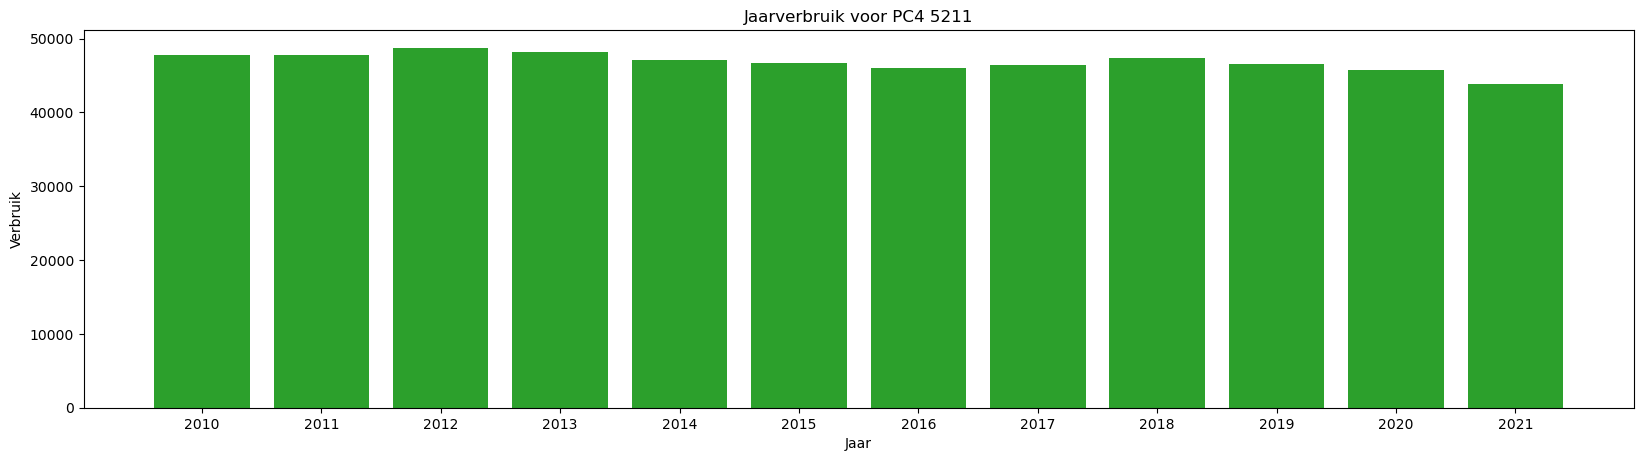

In [106]:
# Maak een plot van het PC4 gebied 5211 vwt verbruik
plt.figure(figsize=(20,5), dpi=100)
plt.bar(x_values, y_values, color='tab:green')
plt.xticks(x_values)
plt.xlabel("Jaar")
plt.ylabel("Verbruik")
plt.gca().set(title='Jaarverbruik voor PC4 5211')
plt.show()

In [122]:
df_transform_nedu[df_transform_nedu.PROFIEL=='E1A']

,DATUM,PROFIEL,VERBRUIKS_FACTOR,JAAR
0,2010-01-01,E1A,0.003231,2010
5,2010-01-02,E1A,0.003448,2010
10,2010-01-03,E1A,0.003314,2010
15,2010-01-04,E1A,0.003275,2010
20,2010-01-05,E1A,0.003232,2010
...,...,...,...,...
21895,2021-12-28,E1A,0.003457,2021
21900,2021-12-29,E1A,0.003636,2021
21905,2021-12-30,E1A,0.003527,2021
21910,2021-12-31,E1A,0.003377,2021


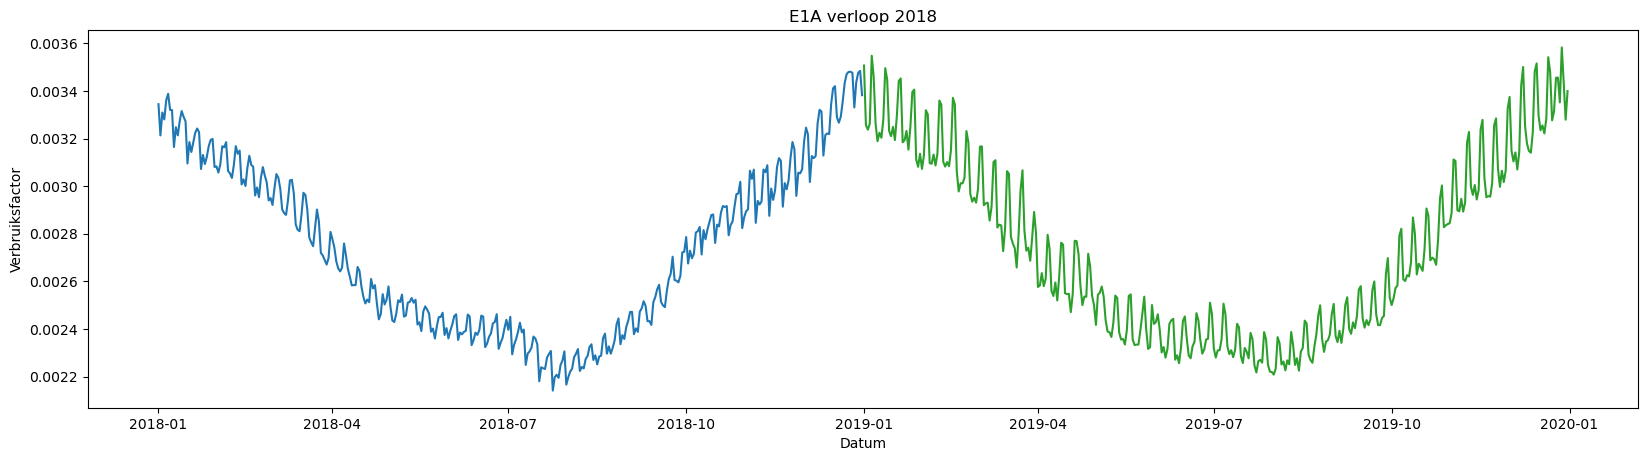

In [136]:
# Time series plot voor 2010. Controle of alle data visueel ook correct lijkt
plt.figure(figsize=(20,5), dpi=100)
plt.plot(df_transform_nedu[(df_transform_nedu.PROFIEL=='E1A') & (df_transform_nedu.JAAR==2018)].DATUM, df_transform_nedu[(df_transform_nedu.PROFIEL=='E1A') & (df_transform_nedu.JAAR==2018)].VERBRUIKS_FACTOR, color='tab:blue')
plt.plot(df_transform_nedu[(df_transform_nedu.PROFIEL=='E1A') & (df_transform_nedu.JAAR==2019)].DATUM, df_transform_nedu[(df_transform_nedu.PROFIEL=='E1A') & (df_transform_nedu.JAAR==2019)].VERBRUIKS_FACTOR, color='tab:green')
plt.gca().set(title='E1A verloop 2018', xlabel='Datum', ylabel='Verbruiksfactor')
plt.show()

In [45]:
# een sample nemen uit de verbruiks data 
# en deze joinen met de df_transform_nedu data
df_sample = df_verbruik[['RES','PC4','JAAR','SJV_TOTAAL','PROFIEL']][df_verbruik['PC4'] == 5211]
df_sample = pd.merge(df_sample, df_transform_nedu, on=['JAAR','PROFIEL'], how='left')

# verbruik per dag berekenen
df_sample['VERBRUIK'] =  df_sample['SJV_TOTAAL'] * df_sample['VERBRUIKS_FACTOR']

# df_verbruik is nog per pc6, dus eerst omzetten naar pc4
df_sample_pc4 = df_sample.groupby(['RES','PC4','DATUM'], as_index=False).agg(VERBRUIK = ('VERBRUIK', 'sum'))
df_sample_pc4 = pd.DataFrame(df_sample_pc4[['DATUM','VERBRUIK']]).set_index('DATUM')
df_sample_pc4.head()

,VERBRUIK
DATUM,
2019-01-01,146.355223
2019-01-02,151.441277
2019-01-03,152.277352
2019-01-04,154.106294
2019-01-05,156.665370
2019-01-06,147.705705
2019-01-07,150.269271
2019-01-08,148.319910
2019-01-09,150.903689


In [52]:
# Check de inhoud van 2019
df_sample_pc4[df_sample_pc4.index.year == 2019][:20]

,VERBRUIK
DATUM,
2010-01-01,135.991828
2010-01-02,153.691311
2010-01-03,138.770371
2010-01-04,152.239911
2010-01-05,154.128008


In [109]:
df_sample_pc4.index.year.value_counts()

2012    366
2016    366
2020    366
2013    365
2017    365
2021    365
2010    365
2014    365
2018    365
2011    365
2015    365
2019    365
Name: DATUM, dtype: int64

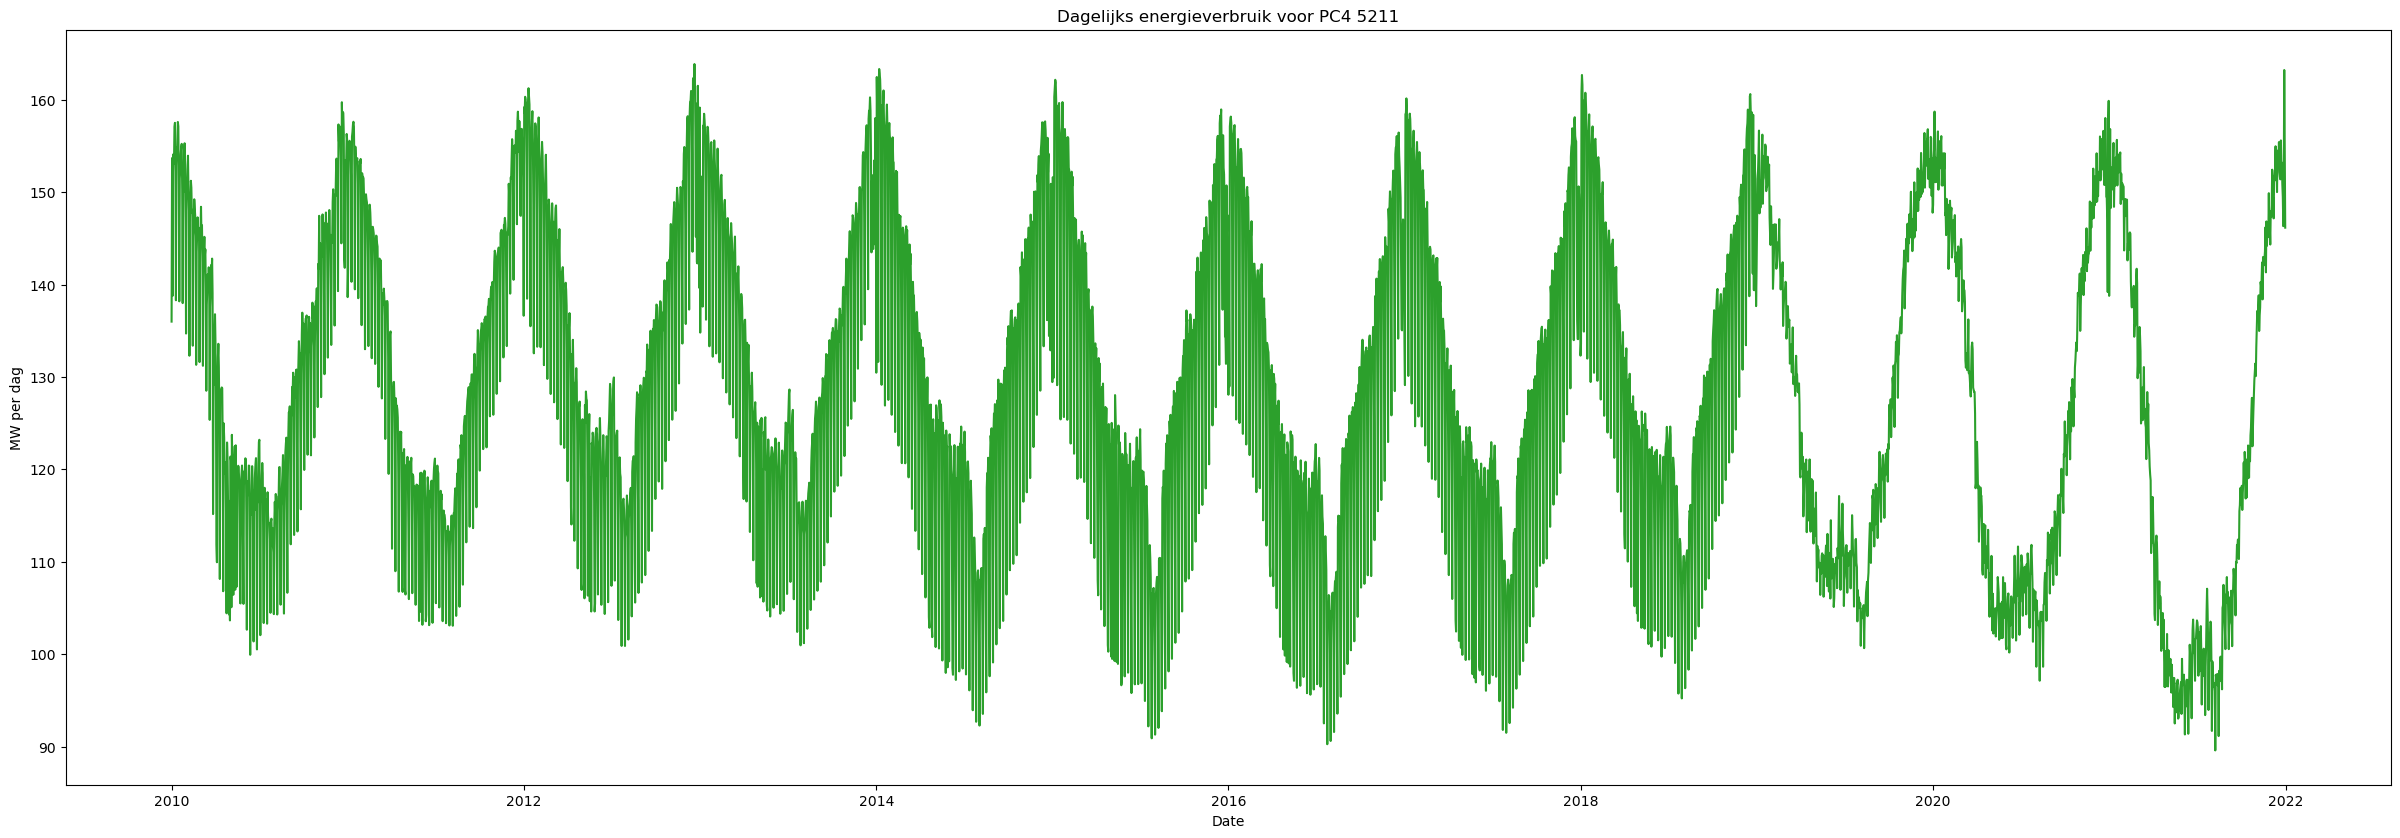

In [13]:
# Time series plot. Visuele check van de uitkomst
plt.figure(figsize=(30,10), dpi=100)
plt.plot(df_sample_pc4.index, df_sample_pc4.VERBRUIK, color='tab:green')
plt.gca().set(title='Dagelijks energieverbruik voor PC4 5211', xlabel='Date', ylabel='MW per dag')
plt.show()

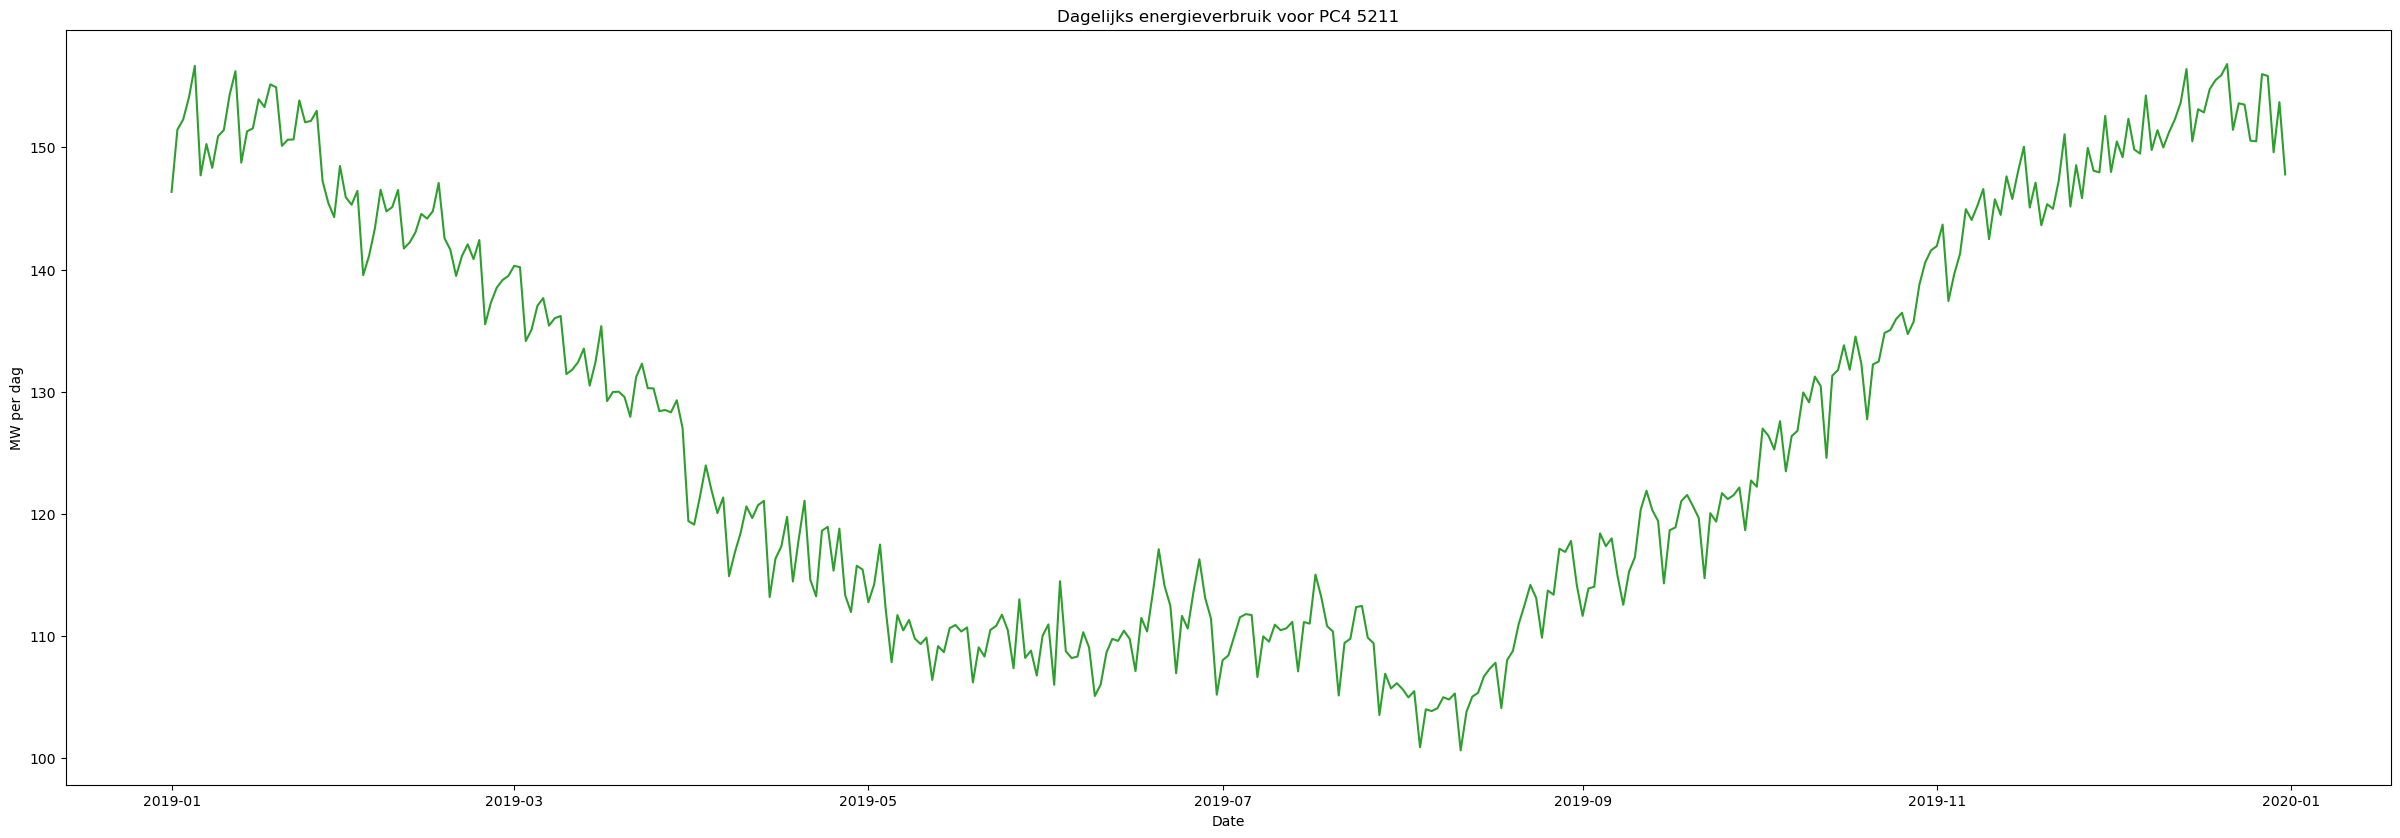

In [14]:
# Time series plot. Visuele check van de uitkomst
plt.figure(figsize=(30,10), dpi=100)
plt.plot(df_sample_pc4[df_sample_pc4.index.year == 2019].index, df_sample_pc4[df_sample_pc4.index.year == 2019].VERBRUIK, color='tab:green')
plt.gca().set(title='Dagelijks energieverbruik voor PC4 5211', xlabel='Date', ylabel='MW per dag')
plt.show()

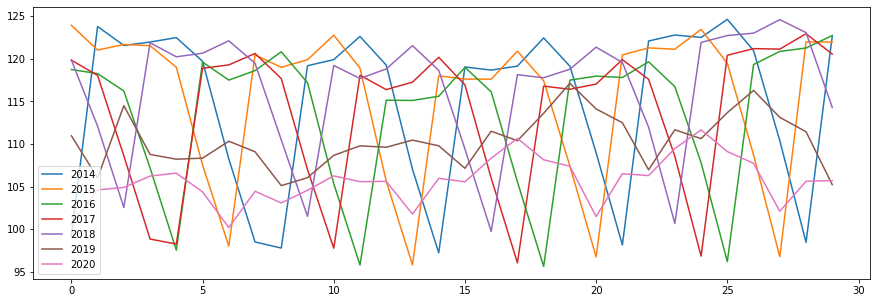

In [15]:
# Set start and end dates mm-dd
start_date='06-01'
end_date ='06-30'

# Set year range
start_year = 2014
end_year = 2020

# set up plot
fig, ax = plt.subplots(figsize=(15,5))

# Loop over years in year_range
for year in range(start_year,end_year+1):
    start_index = str(year)+'-'+start_date
    end_index = str(year)+'-'+end_date
    df=df_sample_pc4[start_index:end_index].reset_index()
    ax.plot(df['VERBRUIK'], label=str(year))
    ax.legend()
    

In [17]:
data_processed_location = '../data/processed'

if 'processed' not in os.getcwd():
    os.chdir(data_processed_location)

try:
    os.remove('pc4_verbruiksdata_per_dag_5211.h5')
except:
    print ('File nog in gebruik of niet gevonden')

store = pd.HDFStore('pc4_verbruiksdata_per_dag_5211.h5')
store['pc4_verbruiksdata_per_dag_5211'] = df_sample_pc4
store.close()

# Einde Test dataframe voor 1 PC4

# Bouw dataframe voor alle PC4s

In [18]:
# Build a frame per PC4
print ("Lijst met PC4 codes samenstellen", end="..")
PC4_list = df_verbruik.PC4.unique()
pc4_count = len(PC4_list)
print (f"klaar. Er zijn {pc4_count} pc4 codes")

Lijst met PC4 codes samenstellen..klaar. Er zijn 1647 pc4 codes


In [19]:
# Maak een samengevoegd dataframe per pc4/RES
i = 1
df_end_frame = None
overall_start = time.time()
def do_per_pc4(pc4):
    global i, df_end_frame
    start = time.time()

    print(f'{format(i,"04d")}. Samenvoegen NEDU profielen en verbruiksdata voor {pc4}', end = '..')
    i = i + 1

    # Maak kleiner frame
    df_sample = df_verbruik[['RES','PC4','JAAR','SJV_TOTAAL','PROFIEL']][df_verbruik.PC4 == pc4]
    
    # Voeg samen met de profielen set
    df_sample = pd.merge(df_sample, df_transform_nedu, on=['JAAR','PROFIEL'], how='left')

    # verbruik per dag berekenen
    df_sample['VERBRUIK'] =  df_sample.SJV_TOTAAL * df_sample.VERBRUIKS_FACTOR

    # df_verbruik is nog per pc6, dus eerst omzetten naar pc4
    df_sample = df_sample.groupby(['RES','PC4','DATUM'], as_index=False).agg(VERBRUIK = ('VERBRUIK', 'sum'))
    df_sample = df_sample.set_index('DATUM')

    # Voeg het sample toe aan het eindframe
    if df_end_frame is None:
        df_end_frame = df_sample.copy()
    else:
        df_end_frame = df_end_frame.append(df_sample)

    end = time.time()
    exec_tijd = format(end - start, '.2f')
    print(f'done in {exec_tijd}s')

    return i

# Doe voor alle pc4 entries
for pc4 in PC4_list:
    i = do_per_pc4(pc4)

overall_end = time.time()
exec_tijd = overall_end - overall_start
exec_tijd_min = int(exec_tijd / 60)
exec_tijd_sec = int(exec_tijd % 60)
print(f"Totale executietijd is {exec_tijd_min}:{format(exec_tijd_sec, '02d')}")



r 9688..done in 0.18s
1382. Samenvoegen NEDU profielen en verbruiksdata voor 9693..done in 0.22s
1383. Samenvoegen NEDU profielen en verbruiksdata voor 9695..done in 0.29s
1384. Samenvoegen NEDU profielen en verbruiksdata voor 9696..done in 0.17s
1385. Samenvoegen NEDU profielen en verbruiksdata voor 9697..done in 0.28s
1386. Samenvoegen NEDU profielen en verbruiksdata voor 9698..done in 0.20s
1387. Samenvoegen NEDU profielen en verbruiksdata voor 9699..done in 0.20s
1388. Samenvoegen NEDU profielen en verbruiksdata voor 9711..done in 0.50s
1389. Samenvoegen NEDU profielen en verbruiksdata voor 9712..done in 0.48s
1390. Samenvoegen NEDU profielen en verbruiksdata voor 9713..done in 0.57s
1391. Samenvoegen NEDU profielen en verbruiksdata voor 9714..done in 0.35s
1392. Samenvoegen NEDU profielen en verbruiksdata voor 9715..done in 0.49s
1393. Samenvoegen NEDU profielen en verbruiksdata voor 9716..done in 0.32s
1394. Samenvoegen NEDU profielen en verbruiksdata voor 9717..done in 0.41s
139

In [33]:
# Schrijf het samengevoegde dataframe naar een bestand
def write_h5(df):
    file = f"pc4_verbruiksdata"

    # Haal een eventuele vorige versie weg
    try:
        os.remove(file + '.h5')
    except:
        print ("pc4_verbruiksdata.h5 wordt weggeschreven naar disk")
        # Schrijf het bestand weg
        store = pd.HDFStore(file + '.h5')
        store[file] = df
        store.close()

# Schrijf bestand weg
write_h5(df_end_frame)

pc4_verbruiksdata.h5 wordt weggeschreven naar disk


In [31]:
df_end_frame.head()

,RES,PC4,VERBRUIK
DATUM,,,
2010-01-01,West-Brabant,4251,69.210361
2010-01-02,West-Brabant,4251,74.631336
2010-01-03,West-Brabant,4251,69.108457
2010-01-04,West-Brabant,4251,70.974795
2010-01-05,West-Brabant,4251,70.388160


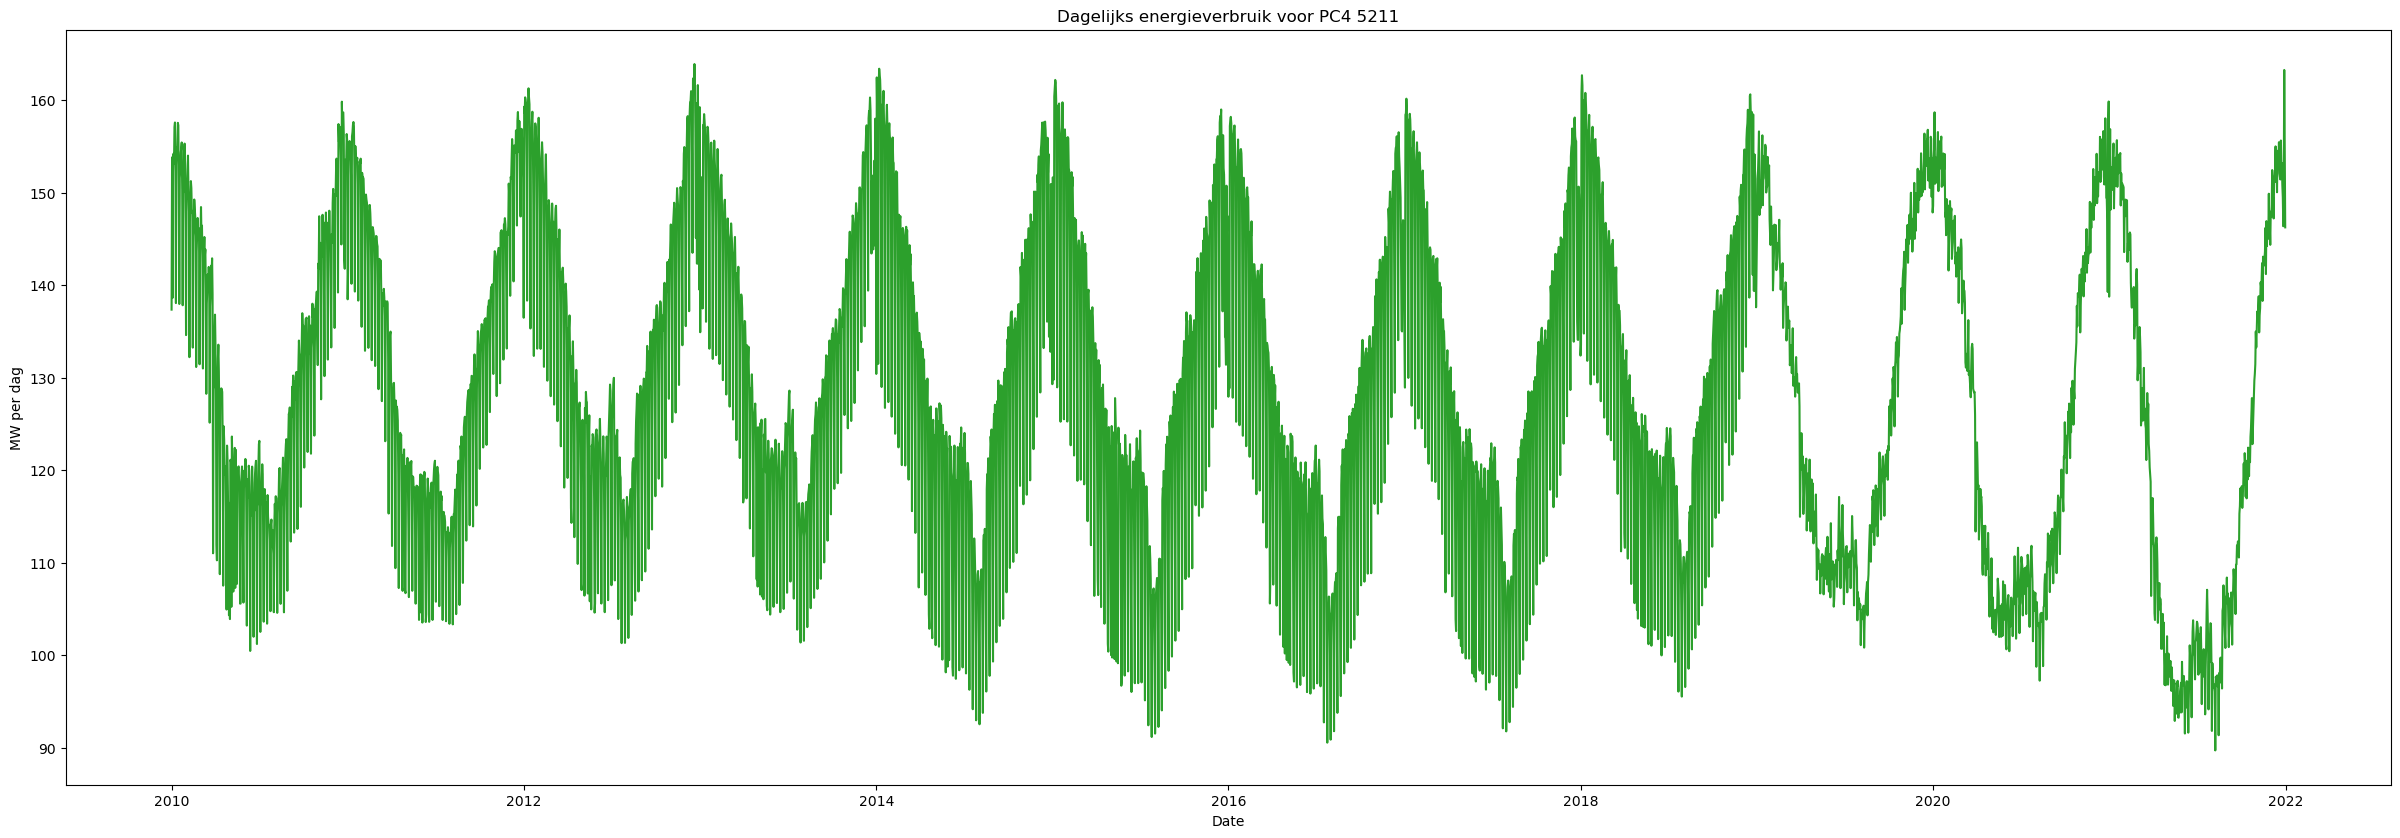

In [32]:
# Time series plot. Visuele check van de uitkomst. Zou hetzelfde plaatje moeten zijn als hierboven
plt.figure(figsize=(30,10), dpi=100)
plt.plot(df_end_frame[df_end_frame.PC4 == 5211].index, df_end_frame[df_end_frame.PC4 == 5211].VERBRUIK, color='tab:green')
plt.gca().set(title='Dagelijks energieverbruik voor PC4 5211', xlabel='Date', ylabel='MW per dag')
plt.show()